# U-net for parcellation

- trained on cortical parcellations from Freesurfer
- (TO DO) finetuned on small dataset of "expert" hand-labels
- predicts output class for each pixel of input image

In [1]:
# I also like to live dangerously
import warnings
warnings.filterwarnings('ignore')

In [2]:
import user

In [3]:
from user.utils import y_vis_sample, from_onehot

In [3]:
import unet

In [4]:
import visual_autolabel as va
import user
from user.data import ToFloat

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# these are required for defining the regession ImageFolder
from typing import Dict, Any
from torchvision import datasets
from torchsummary import summary

In [5]:
import nilearn as ni
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import os
import numpy as np
import pandas as pd

from PIL import Image
from PIL import ImageOps
from PIL import ImagePalette

## 1. Set up directories and process data

In [6]:
in_channels = 1
out_channels = 21

In [7]:
def make_mapping_file(xdir, ydir, ldir, mapping_fname):
    if mapping_fname is None:
        mapping_fname = 'mapping_file.csv'
    
    x_fnames = os.listdir(xdir)
    y_fnames = os.listdir(ydir)
    x_id = [''.join(f.split('curv'))[:-4] for f in x_fnames]
    y_id = [''.join(f.split('parc'))[:-4]for f in y_fnames]

    x_df = pd.DataFrame({'Xname': x_fnames, 'ID': x_id})
    y_df = pd.DataFrame({'Yname': y_fnames, 'ID': y_id})

    mapping_df = pd.merge(x_df, y_df, how='inner', on='ID')
    mapping_df = mapping_df[['Xname', 'Yname', 'ID']]
    mapping_df.to_csv(f'{ldir}/{mapping_fname}', index=False, mode='w+')

## Create test-train split respecting subject EIDs

In [8]:
base_dir = '/scratch/groups/jyeatman/samjohns-projects/data/parc-images-jitter-processed'
xdir = base_dir + '/curv-trans'
ydir = base_dir + '/parc-trans'
ldir = base_dir
mapping_fname = 'mapping_file_jitter_trans.csv'

In [9]:
xdir_train = xdir + '-trn'
ydir_train = ydir + '-trn'
xdir_val = xdir + '-val'
ydir_val = ydir + '-val'

xs = os.listdir(xdir)
ys = os.listdir(ydir)

xeids = [s[:16] for s in xs]
yeids = [s[:16] for s in ys]

os.makedirs(xdir_train, exist_ok=True)
os.makedirs(ydir_train, exist_ok=True)
os.makedirs(xdir_val, exist_ok=True)
os.makedirs(ydir_val, exist_ok=True)

In [10]:
len(set(xeids) & set(yeids)), len(set(xeids)), len(set(yeids))

(2361, 2361, 2361)

In [11]:
xeids_unique = list(set(xeids))
yeids_unique = list(set(yeids))

val_size = len(xeids_unique) // 10
trn_size = len(xeids_unique) - val_size

In [12]:
vals_exist = True
if not vals_exist:
    val_eids = list(np.random.choice(xeids_unique, replace=False, size=val_size))
else:
    val_eids = np.load('val_eids.npy')
trn_eids = list(set(xeids_unique) - set(val_eids))
len(trn_eids), len(val_eids), set(trn_eids) & set(val_eids)

(2125, 236, set())

In [13]:
copy_files = False
if copy_files:
    import shutil
    for y in ys:
        val = y[:16] in val_eids
        dst = ydir_val if val else ydir_train
        if val:
            shutil.copy(f'{ydir}/{y}', dst)
        else:
            shutil.copy(f'{ydir}/{y}', dst)

In [14]:
# make mapping files for train and val sets

mapping_file_exists = True
mapping_fname_trn = 'mapping-jitter-trans-trn.csv'
mapping_fname_val = 'mapping-jitter-trans-val.csv'
if not mapping_file_exists:
    make_mapping_file(xdir_train, ydir_train, ldir, mapping_fname_trn)
    make_mapping_file(xdir_val, ydir_val, ldir, mapping_fname_val)

In [15]:
trn_df = pd.read_csv(f'{ldir}/{mapping_fname_trn}')
val_df = pd.read_csv(f'{ldir}/{mapping_fname_val}')

In [16]:
# test
trn_df.head()

,Xname,Yname,ID
0,sub-NDARFN790WHU-210.62-81.89-curv-trans--12--...,sub-NDARFN790WHU-210.62-81.89-parc-trans--12--...,sub-NDARFN790WHU-210.62-81.89--trans--12--20
1,sub-NDARGB015CT3-208.56-82.77-curv-trans--22-1...,sub-NDARGB015CT3-208.56-82.77-parc-trans--22-1...,sub-NDARGB015CT3-208.56-82.77--trans--22-12
2,sub-NDARKM718VKX-201.47-92.39-curv-trans-0-0.npy,sub-NDARKM718VKX-201.47-92.39-parc-trans-0-0.npy,sub-NDARKM718VKX-201.47-92.39--trans-0-0
3,sub-NDARWE818UA6-219.09-76.41-curv-trans--16-8...,sub-NDARWE818UA6-219.09-76.41-parc-trans--16-8...,sub-NDARWE818UA6-219.09-76.41--trans--16-8
4,sub-NDARMA598JTX-212.60-95.18-curv-trans-0-0.npy,sub-NDARMA598JTX-212.60-95.18-parc-trans-0-0.npy,sub-NDARMA598JTX-212.60-95.18--trans-0-0


In [17]:
len(trn_df), len(val_df) # nice, big dataset

(395760, 44166)

## 1.1 Create dataset(s)

In [10]:
base_dir = '/scratch/groups/jyeatman/samjohns-projects/data/parc-images-jitter-processed'
xdir = base_dir + '/curv-trans'
ydir = base_dir + '/parc-trans'
ldir = base_dir

xdir_train = xdir + '-trn'
ydir_train = ydir + '-trn'
xdir_val = xdir + '-val'
ydir_val = ydir + '-val'

xs = os.listdir(xdir)
ys = os.listdir(ydir)

xeids = [s[:16] for s in xs]
yeids = [s[:16] for s in ys]

In [11]:
RS = transforms.Resize(256)
CC = transforms.CenterCrop(200)
from user.data import aggregate_classes, _make_agg_matrix

n_orig_classes = out_channels
fg_agg_dict = {0: [0], 1: list(range(1, out_channels))}
n_agg_classes = len(fg_agg_dict)
fg_agg_dict

{0: [0],
 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}

In [12]:
null_agg_dict = {i: [i] for i in range(21)}

In [13]:
trf = transforms.Compose([transforms.ToTensor(), user.data.ToFloat()])
target_trf = transforms.Compose([transforms.ToTensor(), user.data.ToLong()])

In [14]:
mapping_fname_trn = 'mapping-jitter-trans-trn.csv'
mapping_fname_val = 'mapping-jitter-trans-val.csv'

mapping_file_trn = f'{base_dir}/{mapping_fname_trn}'
mapping_file_val = f'{base_dir}/{mapping_fname_val}'

In [15]:
ds_trn = user.data.CustomUnetDataset(xdir=xdir_train, ydir=ydir_train,
                                 mapping_file=mapping_file_trn,
                                 transform=trf,
                                 target_transform=target_trf, 
                                 nclasses=out_channels,
                                 agg_dict=None)

ds_val = user.data.CustomUnetDataset(xdir=xdir_val, ydir=ydir_val,
                                 mapping_file=mapping_file_val,
                                 transform=trf,
                                 target_transform=target_trf, 
                                 nclasses=out_channels,
                                 agg_dict=None)

In [16]:
len(ds_trn), len(ds_val)

(395760, 44166)

In [17]:
# create dataloaders

bs = 32
nw = 3  # number of cpu's to use to parallelize dl
pm = False  # whether to pin memory in dl

dl_train = DataLoader(ds_trn, batch_size=bs, shuffle=True, pin_memory=pm)
dl_test = DataLoader(ds_val, batch_size=bs, shuffle=False, pin_memory=pm)

## 1.2 Visualize arrays

In [26]:
di_test = iter(dl_test)
xte, yte = next(di_test)

In [27]:
testx = xte[0]
testy = yte[0]
xte.shape, yte.shape, xte.dtype, yte.dtype

(torch.Size([32, 1, 256, 256]),
 torch.Size([32, 21, 256, 256]),
 torch.float32,
 torch.float32)

In [28]:
ind_to_viz = 0

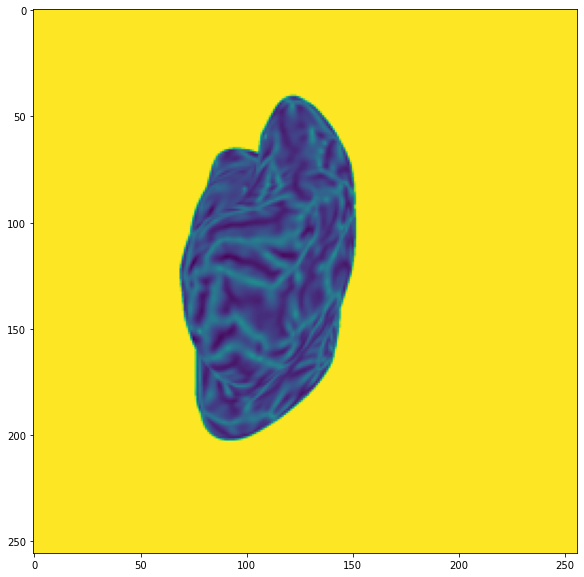

In [29]:
user.utils.imshow(xte[ind_to_viz])

In [30]:
testy_vis = y_vis_sample(yte[ind_to_viz])

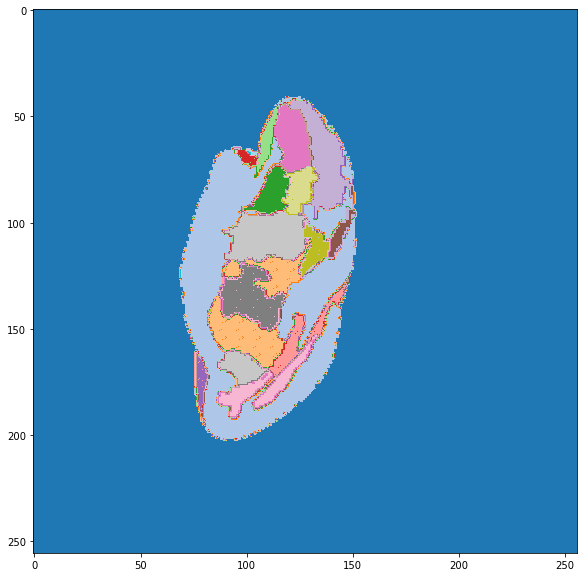

In [31]:
# note: option to specify cmap, e.g. tab20, appropriate for current # of classes
user.utils.imshow(testy_vis, cmap='tab20') # cmap='tab20'

## 2. Define Unet and train

In [18]:
xtr, ytr = next(iter(dl_train))
xte, yte = next(iter(dl_test))

In [19]:
reset_model_var = False
if reset_model_var:
    del model

In [20]:
out_channels_agg = yte.shape[1]
out_channels

21

In [21]:
model = unet.UNet(feature_count=in_channels, class_count=out_channels_agg, apply_sigmoid=False)

### 2.1 Optionally reload model from saved version

In [1]:
model_path = '../models/unet/model_checkpoints_parcellation-5-31.3'

In [63]:
model_ckpts = os.listdir(model_path)

In [64]:
sorted(model_ckpts)

['complete_loss_history.pkl',
 'loss_history_0.pkl',
 'loss_history_100.pkl',
 'loss_history_1000.pkl',
 'loss_history_1100.pkl',
 'loss_history_1200.pkl',
 'loss_history_1300.pkl',
 'loss_history_1400.pkl',
 'loss_history_1500.pkl',
 'loss_history_1600.pkl',
 'loss_history_1700.pkl',
 'loss_history_1800.pkl',
 'loss_history_1900.pkl',
 'loss_history_200.pkl',
 'loss_history_2000.pkl',
 'loss_history_2100.pkl',
 'loss_history_2200.pkl',
 'loss_history_2300.pkl',
 'loss_history_2400.pkl',
 'loss_history_2500.pkl',
 'loss_history_2600.pkl',
 'loss_history_2700.pkl',
 'loss_history_2800.pkl',
 'loss_history_2900.pkl',
 'loss_history_300.pkl',
 'loss_history_3000.pkl',
 'loss_history_3100.pkl',
 'loss_history_3200.pkl',
 'loss_history_3300.pkl',
 'loss_history_3400.pkl',
 'loss_history_3500.pkl',
 'loss_history_3600.pkl',
 'loss_history_3700.pkl',
 'loss_history_3800.pkl',
 'loss_history_3900.pkl',
 'loss_history_400.pkl',
 'loss_history_4000.pkl',
 'loss_history_4100.pkl',
 'loss_history_

In [65]:
model.load_state_dict(torch.load(f'{model_path}/model009900.pkl'))

<All keys matched successfully>

In [23]:
device = user.utils.get_device()
device

device(type='cuda', index=0)

In [24]:
model.to(device)

UNet(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [25]:
summarize = False
if summarize:
    model_summary = summary(model, (1, 256, 256))

In [34]:
# training proceeds along this plan
# shifts weight from bcd to dice
epochs = 2
training_plan = [
    dict(lr=0.00375, gamma=0.9, num_batches=int(1e4),  bce_weight=0.67),
    dict(lr=0.00250, gamma=0.9, num_epochs=epochs,  bce_weight=0.33),
    # dict(lr=0.00125, gamma=0.9, num_epochs=epochs,  bce_weight=0.00)
]

training_plan_short = [dict(lr=0.00375, gamma=0.9, num_batches=int(1e5),  bce_weight=0.67)]

In [35]:
xtr.shape, ytr.shape, xte.shape, yte.shape

(torch.Size([32, 1, 256, 256]),
 torch.Size([32, 21, 256, 256]),
 torch.Size([32, 1, 256, 256]),
 torch.Size([32, 21, 256, 256]))

In [36]:
dl_dict = {'trn': dl_train, 'val': dl_test}

In [39]:
model_save_dir = './model_checkpoints_parcellation-5-31.5'
os.makedirs(model_save_dir, exist_ok=True)

In [ ]:

tp = training_plan_short  # abbreviated for testing
for e, t in enumerate(tp):
    # get hyperparameters
    lr = t['lr']
    gamma = t['gamma']
    bce_weight = t['bce_weight']
    num_batches = t['num_batches']

    # define training objects
    # Create the optimizer.
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    # Next, create the scheduler.
    step_size = len(dl_dict['trn']) 
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=step_size,
        gamma=gamma)

    # train 
    model, best_dice, best_bce, losses = unet.train.train_model(model, optimizer, scheduler, dl_dict, 
                                 save_path=model_save_dir, report_every=5, checkpoint_every=100,
                                 logits=True, num_batches=num_batches,
                                                 logger=None)

Train loss: 0.39459; Val loss: 2.67727; Val bce: 4.42058; Val dice: 0.93395
Train loss: 0.55462; Val loss: 0.55627; Val bce: 0.42127; Val dice: 0.69127
Train loss: 0.47116; Val loss: 0.53516; Val bce: 0.40369; Val dice: 0.66662
Train loss: 0.44592; Val loss: 0.47721; Val bce: 0.35191; Val dice: 0.60252
Train loss: 0.39929; Val loss: 0.51945; Val bce: 0.41357; Val dice: 0.62532
Train loss: 0.41162; Val loss: 0.47000; Val bce: 0.35662; Val dice: 0.58338
Train loss: 0.38628; Val loss: 0.40520; Val bce: 0.29812; Val dice: 0.51227
Train loss: 0.41150; Val loss: 0.53085; Val bce: 0.48914; Val dice: 0.57256
Train loss: 0.35852; Val loss: 0.37764; Val bce: 0.26369; Val dice: 0.49158
Train loss: 0.36391; Val loss: 0.38464; Val bce: 0.27704; Val dice: 0.49225
Train loss: 0.37090; Val loss: 1.64954; Val bce: 2.52508; Val dice: 0.77399
Train loss: 0.35018; Val loss: 0.47891; Val bce: 0.43618; Val dice: 0.52164
Train loss: 0.38643; Val loss: 0.38540; Val bce: 0.27353; Val dice: 0.49728
Train loss: 

Train loss: 0.24582; Val loss: 0.27733; Val bce: 0.18893; Val dice: 0.36573
Train loss: 0.23411; Val loss: 0.45296; Val bce: 0.45136; Val dice: 0.45457
Train loss: 0.23349; Val loss: 0.32823; Val bce: 0.26743; Val dice: 0.38903
Train loss: 0.23668; Val loss: 1.28521; Val bce: 1.91881; Val dice: 0.65160
Train loss: 0.22919; Val loss: 1.25242; Val bce: 1.85828; Val dice: 0.64655
Train loss: 0.24766; Val loss: 1.28108; Val bce: 1.88294; Val dice: 0.67923
Train loss: 0.23565; Val loss: 1.27521; Val bce: 1.90483; Val dice: 0.64558
Train loss: 0.23196; Val loss: 1.21385; Val bce: 1.76418; Val dice: 0.66351
Train loss: 0.23900; Val loss: 0.23440; Val bce: 0.15410; Val dice: 0.31470
Train loss: 0.22372; Val loss: 0.26532; Val bce: 0.18517; Val dice: 0.34548
Train loss: 0.24894; Val loss: 1.21182; Val bce: 1.72679; Val dice: 0.69685
Train loss: 0.23206; Val loss: 1.47443; Val bce: 2.23001; Val dice: 0.71885
Train loss: 0.24612; Val loss: 0.24668; Val bce: 0.16963; Val dice: 0.32373
Train loss: 

Train loss: 0.27089; Val loss: 0.21732; Val bce: 0.16518; Val dice: 0.26945
Train loss: 0.20654; Val loss: 1.75388; Val bce: 2.71314; Val dice: 0.79463
Train loss: 0.22989; Val loss: 1.12040; Val bce: 1.61087; Val dice: 0.62993
Train loss: 0.21023; Val loss: 0.66907; Val bce: 0.82034; Val dice: 0.51779
Train loss: 0.22735; Val loss: 0.25717; Val bce: 0.18213; Val dice: 0.33221
Train loss: 0.20957; Val loss: 0.31443; Val bce: 0.26199; Val dice: 0.36687
Train loss: 0.21042; Val loss: 0.22352; Val bce: 0.14735; Val dice: 0.29970
Train loss: 0.21194; Val loss: 0.22486; Val bce: 0.14962; Val dice: 0.30011
Train loss: 0.23145; Val loss: 0.26519; Val bce: 0.18519; Val dice: 0.34520
Train loss: 0.21810; Val loss: 2.10207; Val bce: 3.33514; Val dice: 0.86900
Train loss: 0.20505; Val loss: 1.31942; Val bce: 1.99541; Val dice: 0.64343
Train loss: 0.26610; Val loss: 0.23866; Val bce: 0.15875; Val dice: 0.31856
Train loss: 0.21374; Val loss: 0.23893; Val bce: 0.15890; Val dice: 0.31896
Train loss: 

## 3. Investigate results

In [2]:
model_save_dir = '../models/unet/model_checkpoints_parcellation-5-31.2'

In [ ]:
os.listdir(model_save_dir)

In [87]:
os.makedirs(model_save_dir, exist_ok=True)
model_fp = f'{model_save_dir}/parc-1.pth'
torch.save(model, model_fp)

In [75]:
load = False
if load:
    model = torch.load(model_fp)
    device = user.utils.get_device()
    model.to(device)

In [88]:
xv_cpu, yv_cpu = next(iter(dl_dict['val']))
xv = xv_cpu.to(device)
yv = yv_cpu.to(device)

In [89]:
model.eval()  # ensure model is in evaluation mode (turns off dropout, etc.)
pred = model(xv)
pred.shape

torch.Size([32, 21, 256, 256])

In [90]:
# visualize Difference between correct and incorrect labels

ind = 5

pred_cpu_sample = y_vis_sample(pred.cpu().detach()[ind])
yv_cpu_sample = y_vis_sample(yv.cpu().detach()[ind])

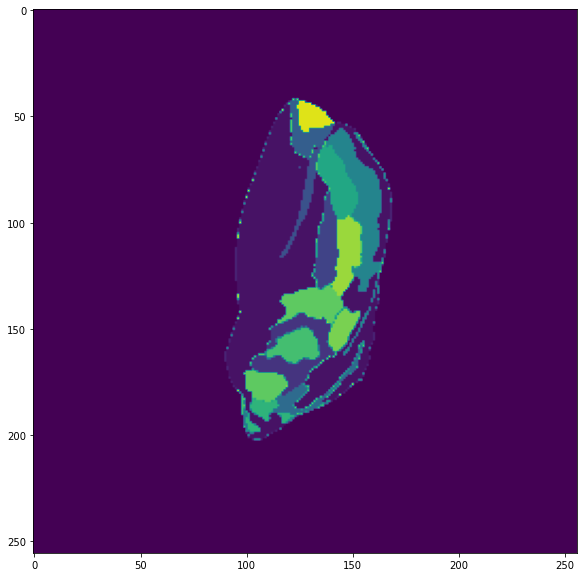

In [91]:
user.utils.imshow(yv_cpu_sample)
# user.utils.imshow(pred_cpu_sample)

In [92]:
pred_am = pred.argmax(dim=1).cpu()
yv_am = yv.argmax(dim=1).cpu()

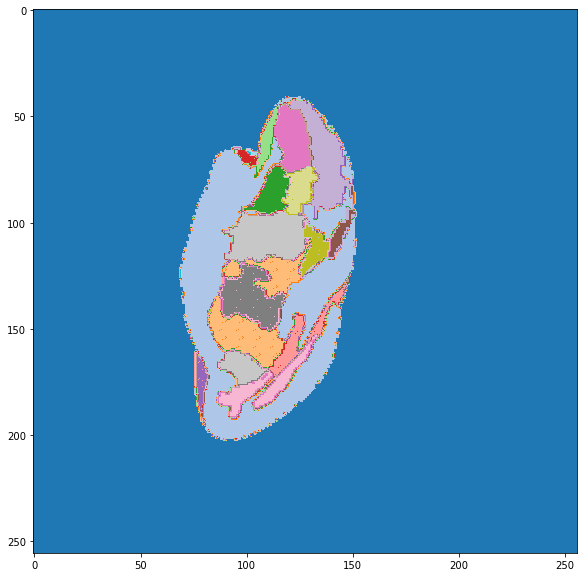

In [93]:
ind = 0

fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(pred_am[ind], cmap='tab20')
plt.imshow(yv_am[ind], cmap='tab20')

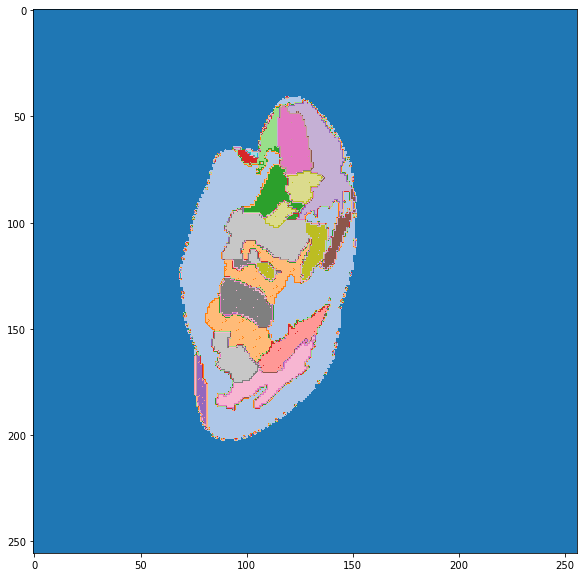

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(pred_am[ind], cmap='tab20')

In [121]:
pred_cpu_sample.shape

torch.Size([1, 256, 256])